In [14]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report ,confusion_matrix, ConfusionMatrixDisplay
import joblib
import logging
import matplotlib.pyplot as plt
from shared_functions import update_accuracy_in_config

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')


In [15]:
def load_data(file_path):
    """
    Load data from a CSV file.

    Args:
        file_path (str): Path to the CSV file containing the data.

    Returns:
        pd.DataFrame: DataFrame containing the loaded data with columns 'text' and 'label'.

    Raises:
        Exception: If there is an error loading the data, an exception is raised.
        
    """
    try:
        df = pd.read_csv(file_path, header=None, names=['text', 'label'], delimiter=',', quoting=3)
        logging.info(f"Data loaded successfully. Shape: {df.shape}")
        return df
    except Exception as e:
        logging.error(f"Error loading data: {str(e)}")
        raise

def preprocess_data(df):
    """
    Preprocess the data by splitting it into training and test sets.

    Args:
        df (pd.DataFrame): DataFrame containing the data with columns 'text' and 'label'.

    Returns:
        tuple: A tuple containing:
            - X_train (pd.Series): Training features (text data).
            - X_test (pd.Series): Test features (text data).
            - y_train (pd.Series): Training labels.
            - y_test (pd.Series): Test labels.
    """
    X = df['text']
    y = df['label']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    logging.info(f"Data split into training and test sets. Training set size: {len(X_train)}, Test set size: {len(X_test)}")
    return X_train, X_test, y_train, y_test

In [16]:

def create_tfidf_vectorizer():
    """
    Create a TfidfVectorizer for transforming text data into TF-IDF features.

    Returns:
        TfidfVectorizer: Configured TfidfVectorizer instance with a maximum of 5000 features and English stop words removed.
    """
    vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
    return vectorizer

def create_model():
    """
    Create a GradientBoostingClassifier for classification tasks.

    Returns:
        GradientBoostingClassifier: Configured GradientBoostingClassifier instance with a fixed random state for reproducibility.
    """
    model = GradientBoostingClassifier(random_state=42)
    return model

In [17]:
def train_model(vectorizer, model, X_train, y_train):
    """
    Train the model using GridSearchCV to find the best hyperparameters.

    Args:
        vectorizer (TfidfVectorizer): The vectorizer to transform the text data.
        model (GradientBoostingClassifier): The model to be trained.
        X_train (pd.Series): Training data features.
        y_train (pd.Series): Training data labels.

    Returns:
        tuple: A tuple containing the fitted vectorizer and the best estimator from GridSearchCV.

    Example:
        >>> vectorizer, trained_model = train_model(vectorizer, model, X_train, y_train)
    """
    X_train_tfidf = vectorizer.fit_transform(X_train)
    
    param_grid = {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5]
    }

    grid_search = GridSearchCV(model, param_grid, cv=3, n_jobs=-1, verbose=1)
    grid_search.fit(X_train_tfidf, y_train)
    
    logging.info(f"Best parameters: {grid_search.best_params_}")
    return vectorizer, grid_search.best_estimator_

In [18]:


def evaluate_model(vectorizer, model, X_test, y_test):
    """
    Evaluate the trained model on the test data and print the accuracy and classification report.

    Args:
        vectorizer (TfidfVectorizer): The vectorizer to transform the test data.
        model (GradientBoostingClassifier): The trained model to evaluate.
        X_test (pd.Series): Test data features.
        y_test (pd.Series): Test data labels.

    Returns:
        tuple: A tuple containing the accuracy score and predictions for the test data.

    Example:
        >>> accuracy, y_pred = evaluate_model(vectorizer, trained_model, X_test, y_test)
    """
    X_test_tfidf = vectorizer.transform(X_test)
    y_pred = model.predict(X_test_tfidf)
    accuracy = accuracy_score(y_test, y_pred)
    logging.info(f'Accuracy: {accuracy}')
    logging.info('Classification Report:')
    logging.info(classification_report(y_test, y_pred))
    return accuracy, y_pred

def save_model(vectorizer, model, file_path):
    """
    Save the vectorizer and the trained model to a file.

    Args:
        vectorizer (TfidfVectorizer): The vectorizer to save.
        model (GradientBoostingClassifier): The model to save.
        file_path (str): The path to the file where the vectorizer and model will be saved.

    Example:
        >>> save_model(vectorizer, trained_model, 'model_and_vectorizer.pkl')
    """
    joblib.dump((vectorizer, model), file_path)
    logging.info(f"Vectorizer and model saved to {file_path}")

In [19]:

# Load data
df = load_data('../sampled_data.csv')

# Preprocess data
X_train, X_test, y_train, y_test = preprocess_data(df)

# Create and train model
vectorizer = create_tfidf_vectorizer()
model = create_model()
vectorizer, trained_model = train_model(vectorizer, model, X_train, y_train)

# Evaluate model
accuracy, y_pred = evaluate_model(vectorizer, trained_model, X_test, y_test)

# Save model
save_model(vectorizer, trained_model, '../trained_models/GBC_TF.pkl')

# Update accuracy in config
update_accuracy_in_config(accuracy, 'tfidf_gradient_boosting')


2024-08-09 15:27:33,102 - INFO - Data loaded successfully. Shape: (3000, 2)
2024-08-09 15:27:33,103 - INFO - Data split into training and test sets. Training set size: 2400, Test set size: 600


Fitting 3 folds for each of 8 candidates, totalling 24 fits


2024-08-09 15:28:20,537 - INFO - Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
2024-08-09 15:28:20,550 - INFO - Accuracy: 0.8883333333333333
2024-08-09 15:28:20,551 - INFO - Classification Report:
2024-08-09 15:28:20,559 - INFO -               precision    recall  f1-score   support

       anger       0.95      0.88      0.92       118
        fear       0.95      0.83      0.89        99
         joy       0.77      0.90      0.83        96
        love       0.91      0.96      0.93       101
     sadness       0.91      0.76      0.83        91
    surprise       0.86      1.00      0.93        95

    accuracy                           0.89       600
   macro avg       0.89      0.89      0.89       600
weighted avg       0.89      0.89      0.89       600

2024-08-09 15:28:20,610 - INFO - Vectorizer and model saved to ../trained_models/GBC_TF.pkl


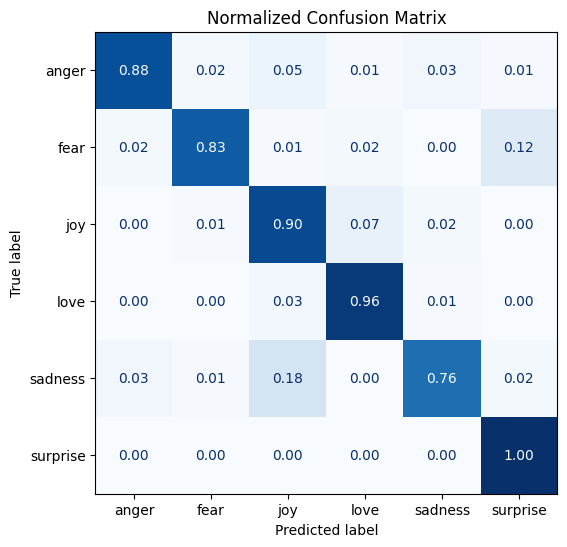

In [20]:

def plot_confusion_matrix(y_predicted, y_true, labels):
    """
    Plot a normalized confusion matrix to visualize classification performance.

    Args:
        y_predicted (array-like): Array of predicted labels from the model.
        y_true (array-like): Array of true labels from the test set.
        labels (array-like): List of class labels to index the matrix. This should match the unique class labels in the dataset.
    """
    cm = confusion_matrix(y_true, y_predicted, normalize='true')
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='Blues', values_format='.2f', ax=ax, colorbar=False)
    plt.title('Normalized Confusion Matrix')
    plt.show()

# Example usage
labels = df['label'].unique()  # Extract unique labels from the DataFrame
plot_confusion_matrix(y_pred, y_test, labels)
